In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [2]:
from datasets import train_test_random_split, load_dsprites
from train import train_beta_vae, test_beta_vae
from loss import loss_beta_vae
from beta_vae import BetaVAEDSprites

In [5]:
dataset = load_dsprites("../datasets/dsprites.npz")

In [6]:
dataset = torch.from_numpy(dataset)

In [7]:
n_imgs = 50000
indices = torch.randperm(dataset.size(0))[:n_imgs]
dataset = dataset[indices]

In [8]:
data_train, data_test = train_test_random_split(dataset, 0.8)

In [13]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [14]:
model = BetaVAEDSprites()
model.to(device)

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [15]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

In [16]:
train_beta_vae(model, 10, train_loader, optimizer, 1, 'bernoulli', device)

Epoch 0 finished, loss: 19652.355412744142
Epoch 1 finished, loss: 164.82986364746094
Epoch 2 finished, loss: 125.59971053466796
Epoch 3 finished, loss: 116.72757449951172
Epoch 4 finished, loss: 112.91416535644531
Epoch 5 finished, loss: 110.68752534179687
Epoch 6 finished, loss: 109.34985520019531
Epoch 7 finished, loss: 108.1805869140625
Epoch 8 finished, loss: 106.92523852539063
Epoch 9 finished, loss: 104.03286986083984


[19652.355412744142,
 164.82986364746094,
 125.59971053466796,
 116.72757449951172,
 112.91416535644531,
 110.68752534179687,
 109.34985520019531,
 108.1805869140625,
 106.92523852539063,
 104.03286986083984]

In [17]:
test_beta_vae(model, test_loader, 1, 'bernoulli', device)

Test loss: 104.09395905512913


In [18]:
torch.save(model, 'betavae_beta1_e10.dat')

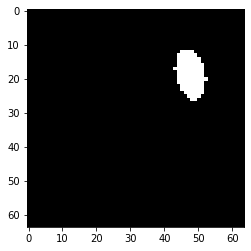

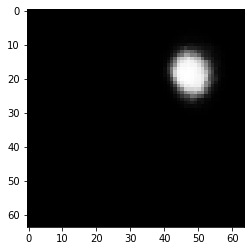

In [30]:
index = 100
original = dataset[index].float().to(device)
recon, mu, logvar = model(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

In [ ]:
torch.save(model, 'betavae_beta1_e10.dat')

In [4]:
model_e10_alldata = torch.load('betavae_beta1_e10_alldata.dat')
model_e10_alldata.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

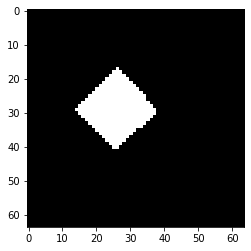

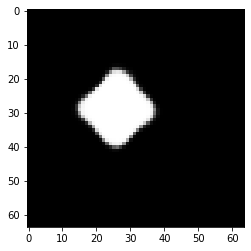

In [15]:
index = 198989
original = dataset[index].float().to(device)
recon, mu, logvar = model_e10_alldata(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

In [16]:
model_e30_alldata = torch.load('betavae_beta1_e30_alldata.dat')
model_e30_alldata.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

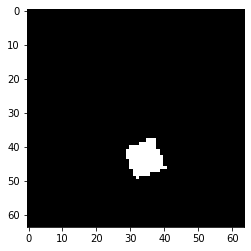

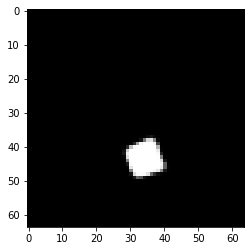

In [20]:
index = 12891
original = dataset[index].float().to(device)
recon, mu, logvar = model_e30_alldata(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()